<a href="https://colab.research.google.com/github/JozefSL/pyNotes/blob/main/pymc3/knownDataCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from google.colab import drive
import os
import sqlite3
import pymc3 as pm
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import rcParams
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
data = pd.DataFrame(np.random.randint(-100,100,size=(1500, 2)), columns=list('xz'))

In [87]:
data.head()

,x,z,y,e
0,-12,-41,14984.239465,1.976709
1,38,92,35583.152074,4.127528
2,-15,-47,16561.460242,6.250990
3,-13,-79,28658.690163,2.470340
4,-89,-85,31234.070462,3.161164


In [86]:
#data['y'] = 100 + 5*data['x'] + 3*data['z'] + np.random.normal(5,20,1500)
data['y'] = 10000 + 5*data['x'] + 3*data['z'].pow(2) + np.random.normal(5,5,1500)

In [77]:
data['e'] = np.random.normal(5,5,1500)

In [89]:
ls_1 = smf.ols('y ~ x + z', data=data).fit()
ls_1.summary(alpha=0.11)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.082
Date:                Mon, 23 May 2022   Prob (F-statistic):              0.339
Time:                        20:49:55   Log-Likelihood:                -15768.
No. Observations:                1500   AIC:                         3.154e+04
Df Residuals:                    1497   BIC:                         3.156e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.055      0.945]
------------------------------------------------------------------------------
Intercept   1.991e+04    229.960     86.599      0.000    1.95e+04    2.03e+04
x              3.2202      3.998      0.805      0.421      -3.173       9.613
z             -5.0989      4.005     -1.273      0.203     -11.503       1.305
==============================================================================
Omnibus:                      227.503   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.315
Skew:                           0.655   Prob(JB):                     3.77e-33
Kurtosis:                       2.179   Cond. No.                         59.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
with pm.Model() as model_ls:
    pm.glm.GLM.from_formula('y ~ x + z**2 ', data)
    step = pm.Metropolis()
    trace_ls = pm.sample(2500, step, tune=2000, init='adapt_diag', cores=2)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [z]
>Metropolis: [x]
>Metropolis: [Intercept]
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 2 chains for 2_000 tune and 2_500 draw iterations (4_000 + 5_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,19918.16,223.60,19478.04,20315.99,7.86,5.56,810.0,1135.0,1.0
x,3.01,3.88,-4.20,10.21,0.12,0.10,997.0,1042.0,1.0
z,-5.02,4.21,-13.73,2.29,0.14,0.10,850.0,739.0,1.0
sd,8905.81,165.14,8620.43,9233.20,5.26,3.72,981.0,1057.0,1.0


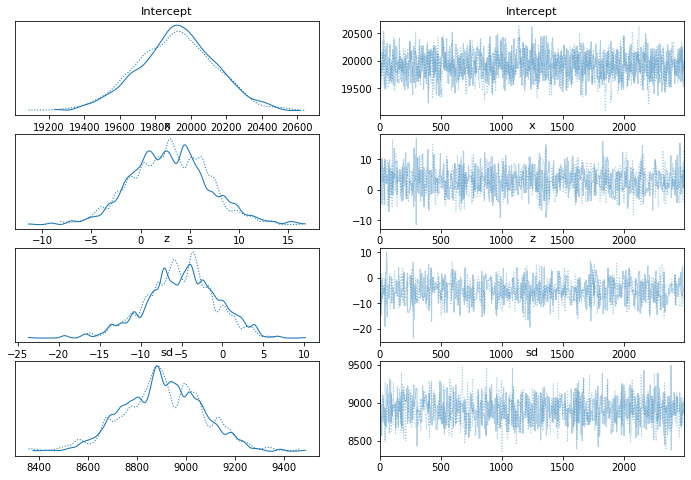

In [91]:
pm.traceplot(trace_ls)
pm.summary(trace_ls).round(2)

In [108]:
with pm.Model() as model_vi1:
# Priors
    #μ_α = pm.Normal('μ_α', mu=30, sd=5)
    #σ_α = pm.Normal('σ_α', mu=0, sd=5)
    # Random intercepts
    #α = pm.Normal('α', mu=μ_α, sd=σ_α, shape=1)
    α = pm.Normal('α', mu=10000, sd=5)
    # Common slope
    b = pm.Normal('b', mu=5, sd=2)
    c = pm.Normal('c', mu=3, sd=2)

   
    # Model error
    ϵ = pm.Normal('ϵ', mu=20,  sd=15)

    μ = α + b*data['x'] + c*data['z']**2
    # Data likelihood
    y = pm.Normal('y', μ, ϵ, observed=data.y)

    trace_vi1 = pm.sample(2000, tune=2500, cores=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, c, b, α]


Sampling 2 chains for 2_500 tune and 2_000 draw iterations (5_000 + 4_000 draws total) took 24 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


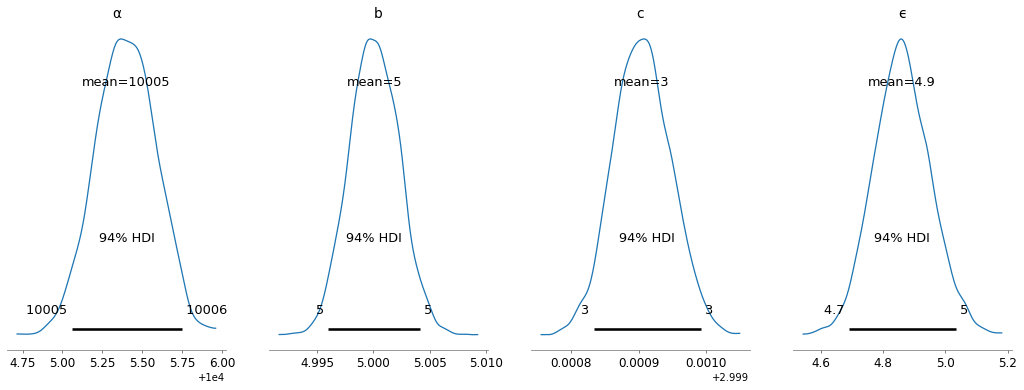

In [123]:
pm.plot_posterior(trace_vi1, var_names=['α', 'b', 'c', 'ϵ'],
                  figsize=(18,6), textsize=12);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5414595b90>,
      dtype=object)

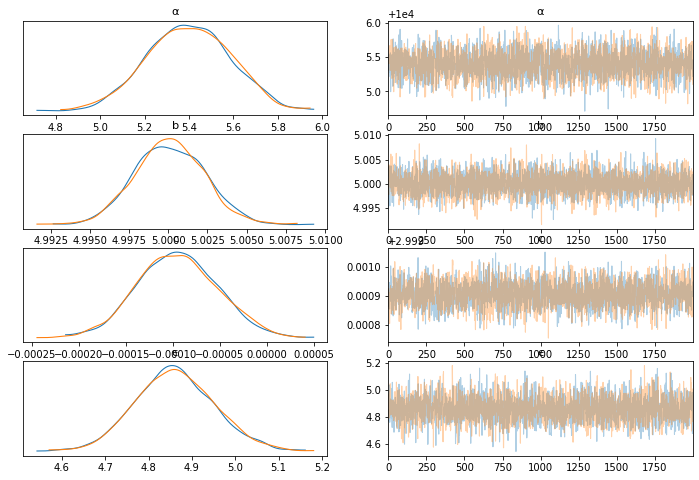

In [116]:
pm.traceplot(trace_vi1, compact=False, combined=False, var_names=['α', 'b', 'c', 'ϵ'])
#pm.summary(trace_vi1).round(2)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


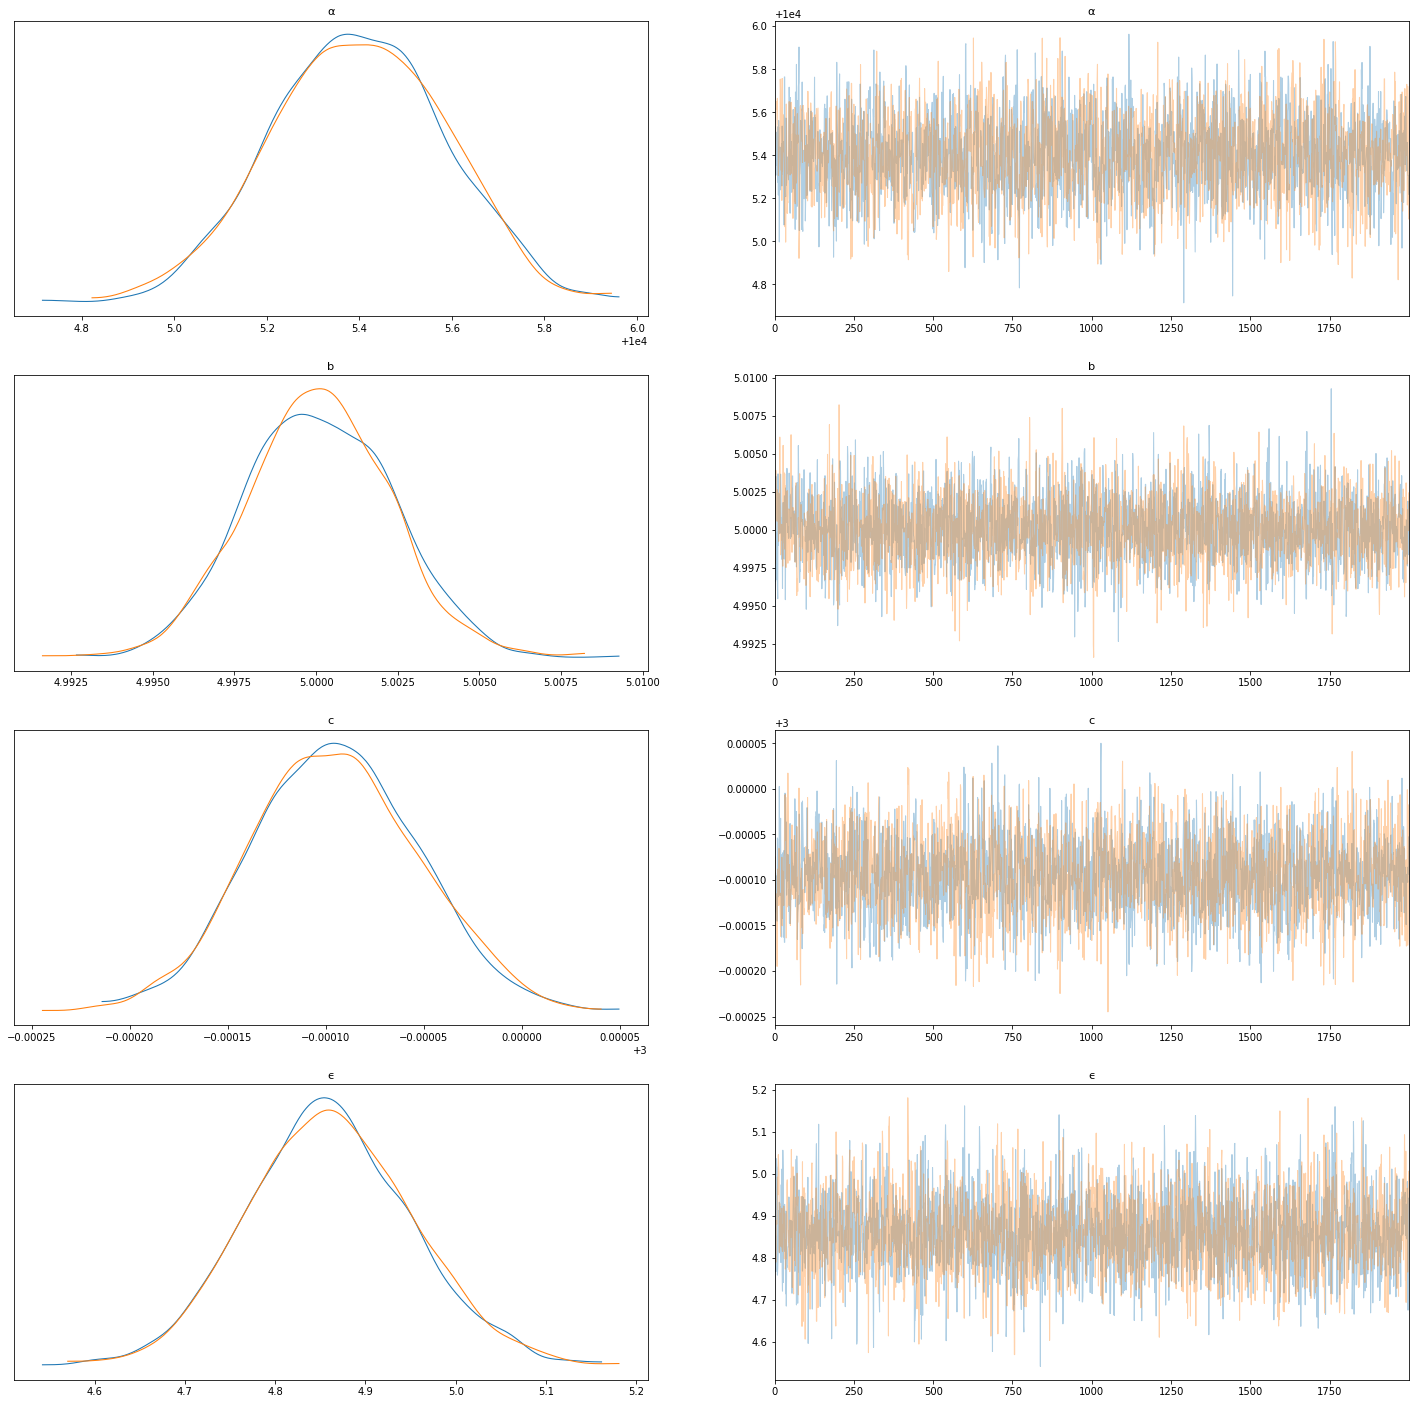

In [121]:
az.plot_trace(trace_vi1, compact=False, figsize=(25, 25), combined=False);

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `kdeplot` from PyMC3 is just an alias for `plot_kde` from ArviZ. Please switch to `pymc3.plot_kde` or `arviz.plot_kde`.
  This is separate from the ipykernel package so we can avoid doing imports until


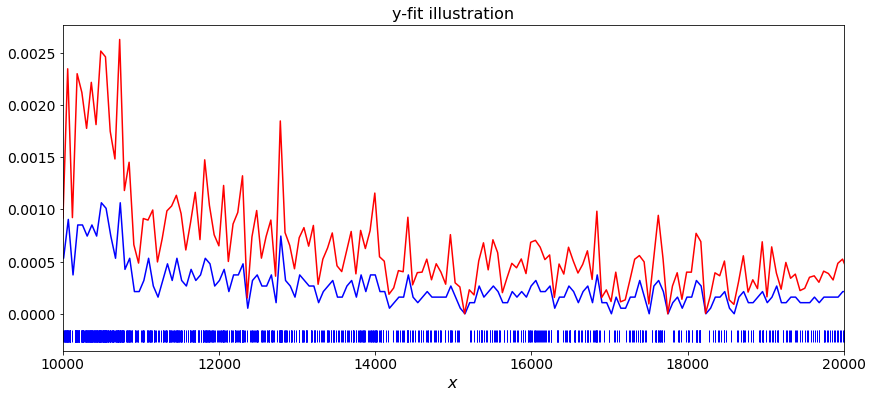

In [128]:
ppc1 = pm.sample_posterior_predictive(trace_vi1, 2000, model_vi1)
rcParams['figure.figsize'] = 14,6
ax = pm.kdeplot(data['y'], plot_kwargs={'color': 'blue'}, bw=5, rug=True)
az.plot_kde(ppc1['y'], plot_kwargs={'color': 'red'}, ax=ax, bw=2)
plt.xlim(10000, 20000)
plt.title("y-fit illustration", fontsize=16)
plt.xlabel('$x$', fontsize=16);

In [130]:
az.r2_score(np.array(data.y), ppc1['y'])

r2        9.999994e-01
r2_std    2.240931e-08
dtype: float64